# Worksheet 17

Name:  Raktim Verma
UID: U80157829

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

Collect User Feedback: Start by collecting user feedback on movies they've watched. Instead of numerical ratings, users would simply indicate whether they liked or disliked a movie.
Feature Representation: Represent each movie and user with relevant features. These features could include genre, actors, director, release year, etc.
Similarity Calculation: Calculate the similarity between users and movies based on their feature representations. Techniques such as cosine similarity or Jaccard similarity can be used for this purpose.
User Preference Modeling: Build a model to understand user preferences based on their liked and disliked movies. This could involve techniques such as collaborative filtering or content-based filtering.
Recommendation Generation: Once we have a model of user preferences, we can generate recommendations for each user based on movies similar to the ones they liked. We can also take into account the preferences of users with similar tastes.
Feedback Loop: Continuously update the model based on user feedback. As users interact with the system and provide more likes and dislikes, the recommendations can be refined to better match their preferences.
Evaluation: Evaluate the performance of the recommender system using metrics such as precision, recall, or F1 score. This will help assess how well the system is able to recommend movies that users are likely to enjoy.

b) Describe 3 challenges of building a recommender system

- Cold Start Problem:
When a new user joins the platform or a new item is added to the catalog, the recommender system may struggle to provide accurate recommendations because it lacks sufficient data about the user's preferences or the item's characteristics.
Addressing the cold start problem requires innovative strategies such as using demographic information, content-based recommendations, or hybrid approaches to make initial recommendations until enough data is collected.
- Data Sparsity and Scalability:
In large-scale recommender systems, the data matrix representing user-item interactions can become extremely sparse, with most entries being unknown or missing. Sparse data makes it challenging to accurately model user preferences and item similarities.
Furthermore, as the user base and item catalog grow, the computational complexity of recommendation algorithms increases, leading to scalability issues.
Techniques such as matrix factorization, dimensionality reduction, and distributed computing frameworks like Apache Spark can help mitigate these challenges by efficiently processing large-scale data.
- Overfitting and Serendipity:
Overfitting occurs when a recommender system learns from noise or outliers in the training data, resulting in recommendations that are too specific to individual users' past behavior and lack diversity.
On the other hand, the system may fail to recommend novel or unexpected items that users might enjoy (serendipity), as it tends to prioritize popular or similar items.
Balancing between personalized recommendations and diversity is crucial. Techniques like regularization, ensemble methods, and incorporating diversity measures into recommendation algorithms can help address overfitting and promote serendipitous recommendations.

c) Why is SVD not an option for collaborative filtering?

While Singular Value Decomposition (SVD) is a potent mathematical tool widely employed in various domains for dimensionality reduction, its direct application to collaborative filtering poses several challenges:

- Sparse Data Handling:
Sparse matrices, a common occurrence in collaborative filtering due to users interacting with only a fraction of available items, present a hurdle for traditional SVD. SVD expects a complete matrix, which may result in misleading interpretations when applied to sparse matrices with missing values.
- Computational Complexity:
The computational demands of SVD can be formidable, particularly as datasets grow in size. With a complexity of 
O(min(M^2 * n, m* N^2)) represent the number of users and items respectively, executing SVD on large matrices becomes impractical for real-time systems.
- Scalability and Dynamic Updates:
SVD lacks inherent mechanisms to efficiently handle dynamic updates to the data matrix. Incorporating new users, items, or updated ratings necessitates recalculating the entire decomposition, making it less viable for systems requiring continual updates.
Alternative Approaches in Collaborative Filtering:

In response to these challenges, alternative techniques have emerged:

- Matrix Factorization Techniques: Methods such as Alternating Least Squares (ALS) and Stochastic Gradient Descent (SGD) based matrix factorization offer scalability and efficiency, enabling incremental updates and better handling of sparse data.
- Regularized SVD: Variants of SVD, such as Regularized SVD or SVD++, address sparsity issues by introducing regularization terms to prevent overfitting and improve performance on incomplete datasets.
- Implicit Feedback Models: For scenarios where explicit ratings are sparse or unavailable, models incorporating implicit feedback, such as user interactions like clicks or views, provide valuable insights and mitigate the challenges associated with traditional SVD approaches.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  1.4284402073032314


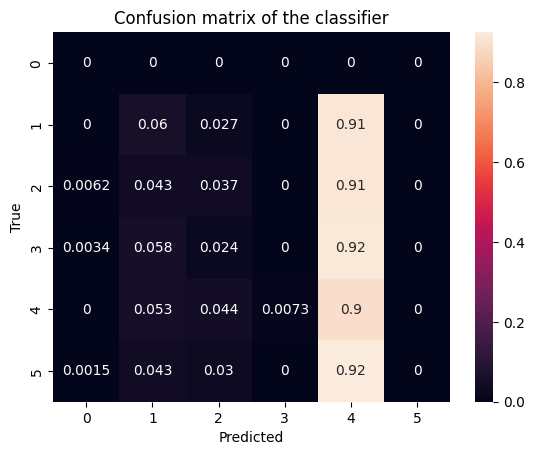

In [13]:
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS

# Initialize findspark and Spark session
findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

# Load the dataset
init_df = pd.read_csv("./train (1).csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
    init_df.drop(['Score'], axis=1),
    init_df['Score'],
    test_size=1/4.0,
    random_state=0
)

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])

# Setup and train the ALS model
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
rec_sys = als.fit(df)

# Use the trained model to make predictions on the test set
X_test_processed_spark_df = spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])
predictions = rec_sys.transform(X_test_processed_spark_df).toPandas()
X_test_processed = X_test_processed.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

result = pd.merge(X_test_processed, predictions, on=['UserId_fact', 'ProductId_fact'], how='left')

average_rating = Y_train.mean()
result['prediction'].fillna(average_rating, inplace=True)
X_test_processed['Score'] = result['prediction'].values

# Evaluate the model using RMSE
rmse = mean_squared_error(Y_test, X_test_processed['Score'], squared=False)
print("Kaggle RMSE = ", rmse)

# Generate and display confusion matrix
cm = confusion_matrix(Y_test.round(), X_test_processed['Score'].round(), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()